prerequisites:  
tenpy: https://tenpy.github.io/INSTALL.html  
tensorflow: https://www.tensorflow.org/install  

In [1]:
from AD_tools import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv2D,Conv1D,MaxPooling2D,MaxPooling1D,UpSampling2D,UpSampling1D,Flatten, Activation, BatchNormalization, GlobalAveragePooling2D,add

In [2]:
tf.__version__

'1.12.0'

In [3]:
import tenpy
tenpy.__version__

'0.4.1'

# Load data
This was previously calcualted on a separate session for 130x100 states for the whole phase diagram

In [4]:
Us = np.concatenate([np.linspace(0.,2.,30),np.linspace(2.,8,100)])
Vs = np.linspace(0,5,100)

In [5]:
x_test2D = np.load("test_data/L-64_D-100_spectra.npz",allow_pickle=True)["x_test2D"]
x_test2D.shape

(13000, 100, 1)

# Define CNN

In [6]:
def scc_cnn1D(loss,optimizer,activation0,activation,x_shape):
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    x1 = Conv1D(64, 3, activation=activation0, padding='same')(input_img) # 100 100 64
    x2 = MaxPooling1D(2, padding='same')(x1) # 50 50 64
    x2 = Conv1D(64, 3, activation=activation0, padding='same')(x2) # 50 50 128
    x3 = MaxPooling1D(2, padding='same')(x2) # 25 25 128
    encoded = Conv1D(64, 3, activation=activation0, padding='same')(x3) # 25 25 128

    y=UpSampling1D(2)(encoded) # 50 50 128
    y=add([x2,y]) # 50 50 128
    y=Conv1D(64, 3, activation=activation0, padding='same')(y) # 50 50 128
    y=UpSampling1D(2)(y) # 100 100 128
    y=add([x1,y]) # 100 100 128
    decoded = Conv1D(x_shape[-1], 3, activation=activation, padding='same')(y) # 100 100 4

    cnn = Model(input_img, decoded)

    cnn.compile(loss=loss,optimizer=optimizer)#,metrics=['accuracy']) #adadelta
    return cnn

In [7]:
cnn = scc_cnn1D("mse","adam","relu","relu",(64,1,))
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 1)        0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 64, 64)       256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 32, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 32, 64)       12352       max_pooling1d[0][0]              
__________________________________________________________________________________________________
max_poolin

# Training
Usually compute extra training set from test set, but since test set is big enough we can just use parts of the test set for training

In [8]:
def pick_Us(Umin,Umax):
    return np.arange(np.where(Us>Umin)[0][0]-1,np.where(Us<Umax)[0][-1]+1,1)    
def pick_Vs(Vmin,Vmax):
    return np.arange(np.where(Vs>Vmin)[0][0]-1,np.where(Vs<Vmax)[0][-1]+1,1)    

In [9]:
trains0 = [[(0,1.3),(0,1.3)]]
x_train = []
for train in trains0:
    x_train.append(x_test2D.reshape(130,100,*x_test2D.shape[1:])[pick_Us(*train[1])][:,pick_Vs(*train[0])].reshape(-1,*x_test2D.shape[1:]))
x_train = np.concatenate(x_train)
x_train.shape

(494, 100, 1)

In [10]:
def train_loss2(y_true,y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.sum((y_true - y_pred)**2))

Train on 494 samples, validate on 494 samples
Epoch 1/10
494/494 [==============================] - 4s 8ms/step - loss: 0.9628 - val_loss: 0.2185
Epoch 2/10
494/494 [==============================] - 0s 586us/step - loss: 0.1449 - val_loss: 0.0936
Epoch 3/10
494/494 [==============================] - 0s 627us/step - loss: 0.0941 - val_loss: 0.0788
Epoch 4/10
494/494 [==============================] - 0s 616us/step - loss: 0.0727 - val_loss: 0.0623
Epoch 5/10
494/494 [==============================] - 0s 586us/step - loss: 0.0740 - val_loss: 0.0529
Epoch 6/10
494/494 [==============================] - 0s 582us/step - loss: 0.0574 - val_loss: 0.0431
Epoch 7/10
494/494 [==============================] - 0s 611us/step - loss: 0.0470 - val_loss: 0.0349
Epoch 8/10
494/494 [==============================] - 0s 612us/step - loss: 0.0404 - val_loss: 0.0310
Epoch 9/10
494/494 [==============================] - 0s 572us/step - loss: 0.0578 - val_loss: 0.0787
Epoch 10/10
494/494 [=================

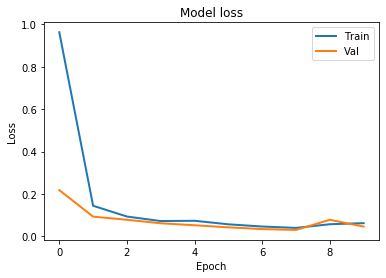

In [11]:
cnn0 = training(x_train, scc_cnn1D, name = "", provide_cnn = False,
             load_prev = False, num_epochs = 10,  verbose_val = 1, batch_size = 24, shuffle = True, early = False,
             loss = train_loss2, activation0 = 'relu', activation = 'tanh', optimizer = "adam")

**Expected Output:**

The expected output should look like this

<img src="Images/Learning_curve2.png">

In [12]:
out = 100*eval_loss(x_test2D,cnn0.predict(x_test2D),norm=norm2) #in order to get percent
out = out.reshape(130,100)

In [13]:
x,y = np.meshgrid(Vs,Us)

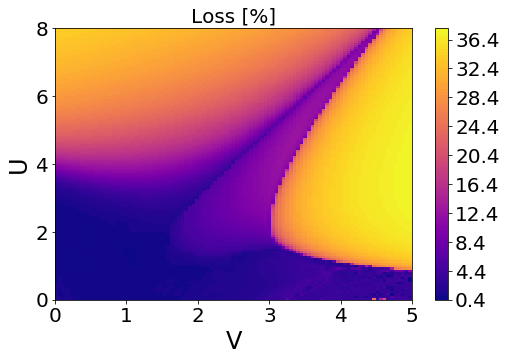

In [14]:
import matplotlib.patches as patches
cmap = plt.get_cmap("plasma") #'viridis'
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)

nbins=100

ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(out.min(),out.max()) #out.max()
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("Loss [%]",fontsize=20)
ax.set_xlabel("V",fontsize=24)
ax.set_ylabel("U",fontsize=24)
ax.tick_params(labelsize=20)
#ax.set_ylim(*ylim)

**Expected Output:**

This should return the whole phase diagram

<img src="Images/Phase_Diagram.png">

Text(0.5, 1.0, 'U = 5.030')

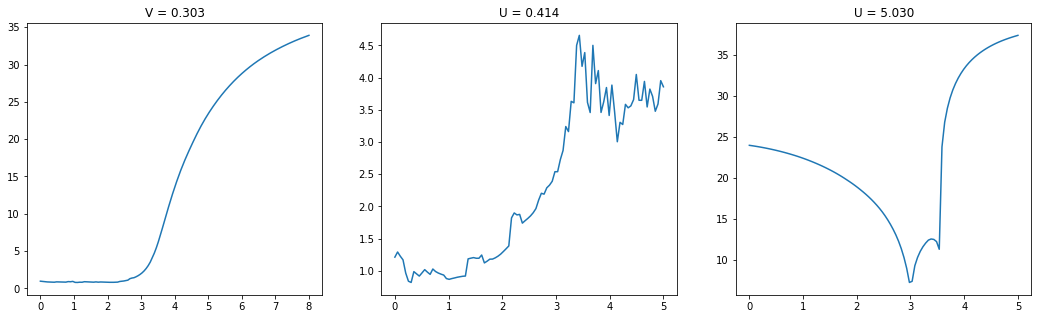

In [15]:
fig,axs = plt.subplots(ncols=3,figsize=(18,5))
ax = axs[0]
col=6
ax.plot(y[:,col],out[:,col])
ax.set_title("V = {:.3f}".format(x[0,col]))

ax = axs[1]
row = 6
ax.plot(x[row],out[row])
ax.set_title("U = {:.3f}".format(y[row,0]))

ax = axs[2]
row = 80
ax.plot(x[row],out[row])
ax.set_title("U = {:.3f}".format(y[row,0]))

**Expected Output:**

This returns you different cross sections of the Phase Diagram:

<img src="Images/Phase_Boundaries1.png">